In [44]:
#  IMPORTS AND SETUP

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve)
import joblib
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Create directories if they don't exist
Path('models').mkdir(exist_ok=True)
Path('logs').mkdir(exist_ok=True)

print("LOAN PAYBACK PREDICTION - ML MODEL TRAINING")
print("\n All libraries imported successfully!")

LOAN PAYBACK PREDICTION - ML MODEL TRAINING

 All libraries imported successfully!


In [45]:
# CELL 2: DATA LOADING
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\user\25RP20399\data\train.csv")

# Display first rows (optional)
print(df.head())


# Display dataset shape
print(f"\n Dataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]:,}")


   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  interest_rate  gender marital_status education_level employment_status        loan_purpose grade_subgrade  loan_paid_back
0   0       29367.99                 0.084           736      2528.42          13.67  Female         Single     High School     Self-employed               Other             C3             1.0
1   1       22108.02                 0.166           636      4593.10          12.92    Male        Married        Master's          Employed  Debt consolidation             D3             0.0
2   2       49566.20                 0.097           694     17005.15           9.76    Male         Single     High School          Employed  Debt consolidation             C5             1.0
3   3       46858.25                 0.065           533      4682.48          16.10  Female         Single     High School          Employed  Debt consolidation             F1             1.0
4   4       25496.70               

In [46]:
# EXPLORATORY DATA ANALYSIS
print("EXPLORATORY DATA ANALYSIS")
print("\n First 5 rows:")
print(df.head())

print("\n Dataset Info:")
df.info()

print("\n Column Names:")
print(df.columns.tolist())

print("\n Data Types:")
print(df.dtypes)

print("\n Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values!")

print("\n Basic Statistics:")
print(df.describe())


EXPLORATORY DATA ANALYSIS

 First 5 rows:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  interest_rate  gender marital_status education_level employment_status        loan_purpose grade_subgrade  loan_paid_back
0   0       29367.99                 0.084           736      2528.42          13.67  Female         Single     High School     Self-employed               Other             C3             1.0
1   1       22108.02                 0.166           636      4593.10          12.92    Male        Married        Master's          Employed  Debt consolidation             D3             0.0
2   2       49566.20                 0.097           694     17005.15           9.76    Male         Single     High School          Employed  Debt consolidation             C5             1.0
3   3       46858.25                 0.065           533      4682.48          16.10  Female         Single     High School          Employed  Debt consolidation             F1          

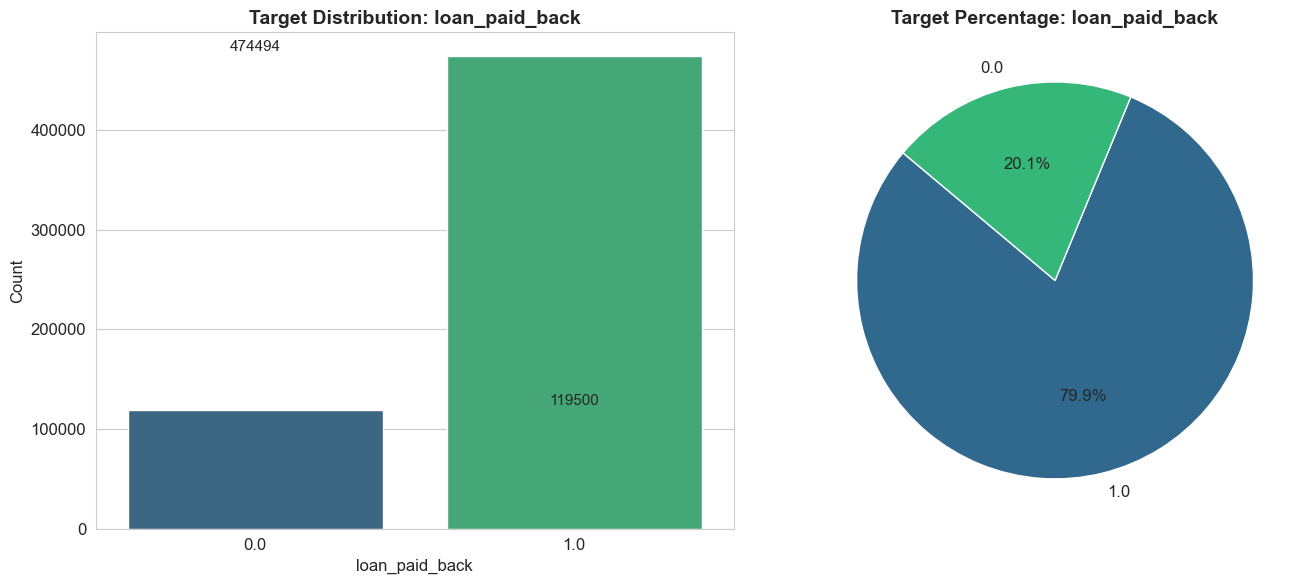

In [47]:


# Set seaborn style for nicer visuals
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Prepare data
counts = df[target_col].value_counts()
percentages = df[target_col].value_counts(normalize=True) * 100

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
sns.barplot(x=counts.index, y=counts.values, ax=ax[0], palette="viridis")
ax[0].set_title(f'Target Distribution: {target_col}', fontsize=14, fontweight='bold')
ax[0].set_xlabel(target_col, fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(counts.values):
    ax[0].text(i, v + max(counts.values)*0.01, str(v), ha='center', fontsize=11)

# Pie chart
ax[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(counts)))
ax[1].set_title(f'Target Percentage: {target_col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [48]:
#  DATA PREPROCESSING
print("DATA PREPROCESSING")

# Make a copy of the dataframe
df_clean = df.copy()

print(f"\n Initial shape: {df_clean.shape}")
print(f"   Missing values: {df_clean.isnull().sum().sum()}")

# Handle missing values
if df_clean.isnull().sum().sum() > 0:
    print("\n Handling missing values...")
    
    # For numeric columns: fill with median
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
            print(f"    Filled {col} with median")
    
    # For categorical columns: fill with mode
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
            print(f"    Filled {col} with mode")
    
    print(f"\n Missing values after cleaning: {df_clean.isnull().sum().sum()}")
else:
    print(" No missing values to handle!")

print(f" Final shape: {df_clean.shape}")


DATA PREPROCESSING

 Initial shape: (593994, 13)
   Missing values: 0
 No missing values to handle!
 Final shape: (593994, 13)


In [49]:
# CELL 7: FEATURE AND TARGET SEPARATION
print("SEPARATING FEATURES AND TARGET")

# Separate features and target
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col} ({X[col].dtype})")



SEPARATING FEATURES AND TARGET
 Features shape: (593994, 12)
 Target shape: (593994,)

Feature columns (12):
  1. id (int64)
  2. annual_income (float64)
  3. debt_to_income_ratio (float64)
  4. credit_score (int64)
  5. loan_amount (float64)
  6. interest_rate (float64)
  7. gender (object)
  8. marital_status (object)
  9. education_level (object)
  10. employment_status (object)
  11. loan_purpose (object)
  12. grade_subgrade (object)


In [50]:
# CELL 8: ENCODE CATEGORICAL FEATURES

print("\n" + "="*70)
print("ENCODING CATEGORICAL FEATURES")
print("="*70)

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns found: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print("\nEncoding categorical features...")
    label_encoders = {}
    
    for col in categorical_cols:
        print(f"  Encoding '{col}'...")
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"    ✓ {len(le.classes_)} unique values encoded")
    
    # Save label encoders
    with open('models/label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)
    print(f"\n✓ Label encoders saved to 'models/label_encoders.pkl'")
else:
    print("✓ No categorical columns to encode!")
    label_encoders = {}




ENCODING CATEGORICAL FEATURES

Categorical columns found: 6

Encoding categorical features...
  Encoding 'gender'...
    ✓ 3 unique values encoded
  Encoding 'marital_status'...
    ✓ 4 unique values encoded
  Encoding 'education_level'...
    ✓ 5 unique values encoded
  Encoding 'employment_status'...
    ✓ 5 unique values encoded
  Encoding 'loan_purpose'...
    ✓ 8 unique values encoded
  Encoding 'grade_subgrade'...
    ✓ 30 unique values encoded

✓ Label encoders saved to 'models/label_encoders.pkl'


In [51]:

# CELL 9: ENCODE TARGET VARIABLE

print("\n" + "="*70)
print("ENCODING TARGET VARIABLE")
print("="*70)

print(f"\nTarget column: '{target_col}'")
print(f"Original values: {y.unique()}")

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nEncoded classes:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name} → {i}")

print(f"\nEncoded target distribution:")
unique, counts = np.unique(y_encoded, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count:,} ({count/len(y_encoded)*100:.2f}%)")

# Save target encoder
with open('models/target_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)
print(f"\n✓ Target encoder saved to 'models/target_encoder.pkl'")

# Update y to encoded version
y = y_encoded





ENCODING TARGET VARIABLE

Target column: 'loan_paid_back'
Original values: [1. 0.]

Encoded classes:
  0.0 → 0
  1.0 → 1

Encoded target distribution:
  Class 0: 119,500 (20.12%)
  Class 1: 474,494 (79.88%)

✓ Target encoder saved to 'models/target_encoder.pkl'


In [52]:

# CELL 10: SAVE COLUMN STRUCTURE

print("\n" + "="*70)
print("SAVING COLUMN STRUCTURE")
print("="*70)

column_names = X.columns.tolist()
print(f"\nTotal features: {len(column_names)}")

# Save column structure
with open('models/column_structure.pkl', 'wb') as f:
    pickle.dump(column_names, f)
print(f"✓ Column structure saved to 'models/column_structure.pkl'")

print("\nFeature list:")
for i, col in enumerate(column_names, 1):
    print(f"  {i:2d}. {col}")



SAVING COLUMN STRUCTURE

Total features: 12
✓ Column structure saved to 'models/column_structure.pkl'

Feature list:
   1. id
   2. annual_income
   3. debt_to_income_ratio
   4. credit_score
   5. loan_amount
   6. interest_rate
   7. gender
   8. marital_status
   9. education_level
  10. employment_status
  11. loan_purpose
  12. grade_subgrade


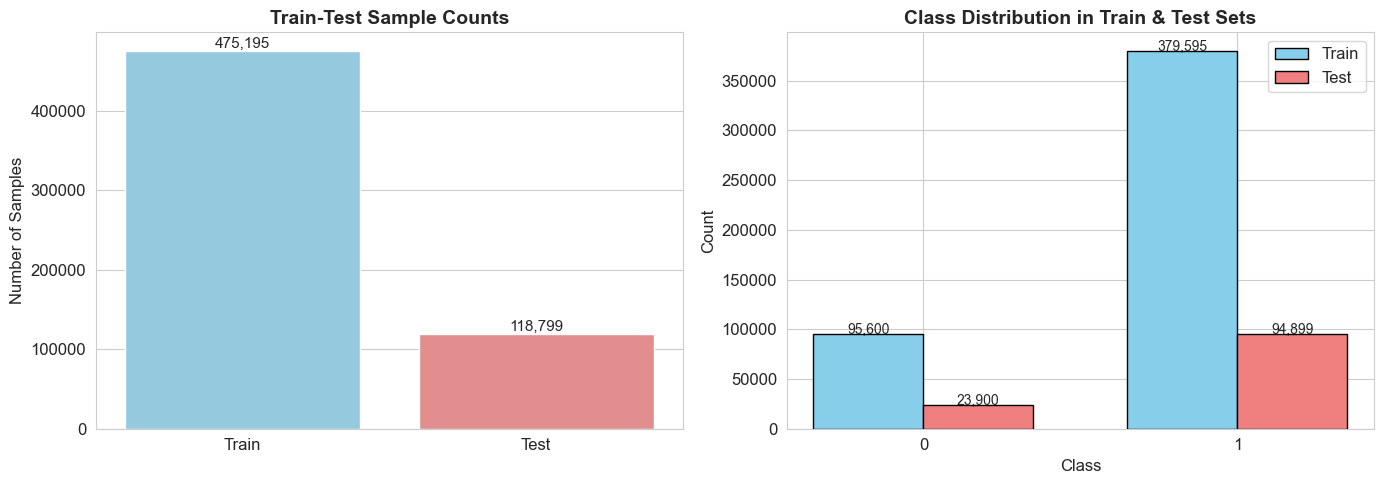

In [53]:

# Set style
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

# Prepare data
train_count = len(y_train)
test_count = len(y_test)

train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()
classes = train_dist.index

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall train-test sample count
sns.barplot(x=['Train', 'Test'], y=[train_count, test_count], ax=axes[0], palette=['skyblue', 'lightcoral'])
axes[0].set_title('Train-Test Sample Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
for i, v in enumerate([train_count, test_count]):
    axes[0].text(i, v + max([train_count, test_count])*0.01, f'{v:,}', ha='center', fontsize=11)

# Right: Class distribution
x = np.arange(len(classes))
width = 0.35
axes[1].bar(x - width/2, train_dist.values, width, label='Train', color='skyblue', edgecolor='black')
axes[1].bar(x + width/2, test_dist.values, width, label='Test', color='lightcoral', edgecolor='black')
axes[1].set_title('Class Distribution in Train & Test Sets', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].legend()

# Add labels on bars
for i in range(len(classes)):
    axes[1].text(i - width/2, train_dist.values[i] + 2, f'{train_dist.values[i]:,}', ha='center', fontsize=10)
    axes[1].text(i + width/2, test_dist.values[i] + 2, f'{test_dist.values[i]:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [54]:

# CELL 12: FEATURE SCALING

print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

print("Applying StandardScaler...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Training set scaled: {X_train_scaled.shape}")
print(f"✓ Test set scaled: {X_test_scaled.shape}")

# Show scaling statistics
print(f"\nScaling statistics (first 5 features):")
for i in range(min(5, len(column_names))):
    print(f"  {column_names[i]}:")
    print(f"    Mean: {X_train_scaled[:, i].mean():.6f}")
    print(f"    Std: {X_train_scaled[:, i].std():.6f}")

# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')
print(f"\n✓ Scaler saved to 'models/scaler.pkl'")

# Save scaled dataset
scaled_data = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_original': X_train,
    'X_test_original': X_test
}
with open('models/scaled_dataset.pkl', 'wb') as f:
    pickle.dump(scaled_data, f)
print(f"✓ Scaled dataset saved to 'models/scaled_dataset.pkl'")




FEATURE SCALING
Applying StandardScaler...
✓ Training set scaled: (475195, 12)
✓ Test set scaled: (118799, 12)

Scaling statistics (first 5 features):
  id:
    Mean: 0.000000
    Std: 1.000000
  annual_income:
    Mean: -0.000000
    Std: 1.000000
  debt_to_income_ratio:
    Mean: 0.000000
    Std: 1.000000
  credit_score:
    Mean: -0.000000
    Std: 1.000000
  loan_amount:
    Mean: 0.000000
    Std: 1.000000

✓ Scaler saved to 'models/scaler.pkl'
✓ Scaled dataset saved to 'models/scaled_dataset.pkl'


In [55]:

# CELL 12: DEFINE MODELS AND HYPERPARAMETERS (OPTIMIZED FOR SPEED)

print("\n" + "="*70)
print("DEFINING MODELS AND HYPERPARAMETERS (FAST VERSION)")
print("="*70)

# OPTIMIZED: Reduced hyperparameter search space
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs']  # Reduced from 2 to 1 solver
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50],      # Reduced from 3 to 2
            'max_depth': [10, None],          # Reduced from 3 to 2
            'min_samples_split': [2, 5]       # Reduced from 3 to 2
            # Removed min_samples_leaf to reduce combinations
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        'params': {
            'n_estimators': [100],       # Reduced from 3 to 2
            'max_depth': [3, 5],              # Reduced from 3 to 2
            'learning_rate': [0.1, 0.3]       # Reduced from 3 to 2
            # Removed subsample and colsample_bytree to reduce combinations
        }
    }
}

print("✓ Models defined (OPTIMIZED FOR SPEED):")
for name in models.keys():
    params = models[name]['params']
    combinations = 1
    for param_values in params.values():
        combinations *= len(param_values)
    print(f"  • {name}")
    print(f"    Parameters: {list(params.keys())}")
    print(f"    Combinations: {combinations} (5-fold CV = {combinations * 5} trainings)")



DEFINING MODELS AND HYPERPARAMETERS (FAST VERSION)
✓ Models defined (OPTIMIZED FOR SPEED):
  • Logistic Regression
    Parameters: ['C', 'solver']
    Combinations: 3 (5-fold CV = 15 trainings)
  • Random Forest
    Parameters: ['n_estimators', 'max_depth', 'min_samples_split']
    Combinations: 4 (5-fold CV = 20 trainings)
  • XGBoost
    Parameters: ['n_estimators', 'max_depth', 'learning_rate']
    Combinations: 4 (5-fold CV = 20 trainings)


In [56]:

# CELL 13: TRAIN MODEL 1 - LOGISTIC REGRESSION (FAST)

print("\n" + "="*70)
print("TRAINING: LOGISTIC REGRESSION")
print("="*70)

name = 'Logistic Regression'
config = models[name]

print(f"\n🔧 Starting Grid Search with 5-Fold CV...")
print(f"   Parameters: {config['params']}")

# Grid Search
grid_search_lr = GridSearchCV(
    config['model'],
    config['params'],
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_scaled, y_train)

# Get best model
best_lr = grid_search_lr.best_estimator_

print(f"\n✓ Grid Search completed!")
print(f"   Best parameters: {grid_search_lr.best_params_}")
print(f"   Best CV score: {grid_search_lr.best_score_:.4f}")

# Cross-validation scores
cv_scores_lr = cross_val_score(best_lr, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\n 5-Fold CV Scores: {cv_scores_lr}")
print(f"   Mean: {cv_scores_lr.mean():.4f}")
print(f"   Std: {cv_scores_lr.std():.4f}")

# Test predictions
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"\n Test Set Performance:")
print(f"   Accuracy: {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")

print(f"\n Classification Report:")
target_names_str = [str(name) for name in le_target.classes_]
print(classification_report(y_test, y_pred_lr, target_names=target_names_str))
# TRAIN ACCURACY
y_train_pred_lr = best_lr.predict(X_train_scaled)
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)

# TEST ACCURACY
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"\n MODEL PERFORMANCE:")
print(f"   Train Accuracy: {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")
print(f"   Test Accuracy:  {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")
print(f"   Difference:     {abs(train_accuracy_lr - test_accuracy_lr):.4f}")

print(f"\n Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)


TRAINING: LOGISTIC REGRESSION

🔧 Starting Grid Search with 5-Fold CV...
   Parameters: {'C': [0.1, 1, 10], 'solver': ['lbfgs']}
Fitting 5 folds for each of 3 candidates, totalling 15 fits

✓ Grid Search completed!
   Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
   Best CV score: 0.8923

 5-Fold CV Scores: [0.89247572 0.89101316 0.89275981 0.8927072  0.89252833]
   Mean: 0.8923
   Std: 0.0007

 Test Set Performance:
   Accuracy: 0.8905 (89.05%)

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.60      0.69     23900
         1.0       0.91      0.96      0.93     94899

    accuracy                           0.89    118799
   macro avg       0.86      0.78      0.81    118799
weighted avg       0.89      0.89      0.88    118799


 MODEL PERFORMANCE:
   Train Accuracy: 0.8923 (89.23%)
   Test Accuracy:  0.8905 (89.05%)
   Difference:     0.0018

 Confusion Matrix:
[[14393  9507]
 [ 3502 91397]]


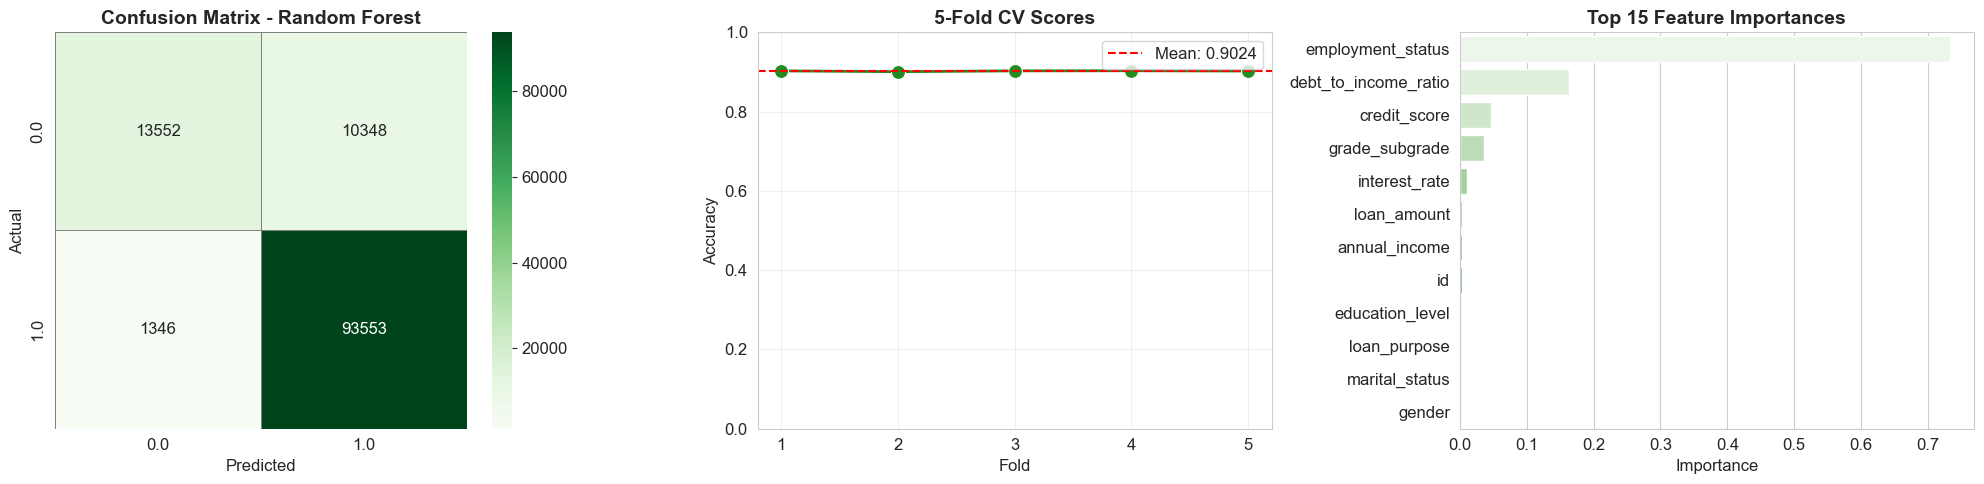

In [57]:


sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

 
top_features = feature_importance.head(15).sort_values('importance')

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1️ Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=le_target.classes_, yticklabels=le_target.classes_,
            linewidths=0.5, linecolor='gray')
axes[0].set_title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Cross-Validation Scores
sns.lineplot(x=range(1, 6), y=cv_scores_rf, marker='o', linewidth=2, markersize=10, color='forestgreen', ax=axes[1])
axes[1].axhline(y=cv_scores_rf.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores_rf.mean():.4f}')
axes[1].set_title('5-Fold CV Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(range(1, 6))
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Feature Importance
sns.barplot(x='importance', y='feature', data=top_features, palette='Greens_r', ax=axes[2])
axes[2].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Importance')
axes[2].set_ylabel('')
axes[2].invert_yaxis()  # Highest importance on top

plt.tight_layout()
plt.show()



TRAINING: XGBOOST (OPTIMIZED)

 Starting Grid Search with 5-Fold CV...
   Parameters: {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.3]}
     Estimated time: 30-60 seconds...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Grid Search completed!
   Best parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
   Best CV score: 0.9042

 5-Fold CV Scores: [0.9039447  0.90377634 0.90416566 0.90504951 0.90426036]
   Mean: 0.9042
   Std: 0.0004

 Test Set Performance:
   Accuracy: 0.9046 (90.46%)

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799


 MODEL PERFORMANCE:
   Train Accuracy: 0.9078 (90.78%)
   Test Accuracy:  0.9046 (90.46%)
   Diff

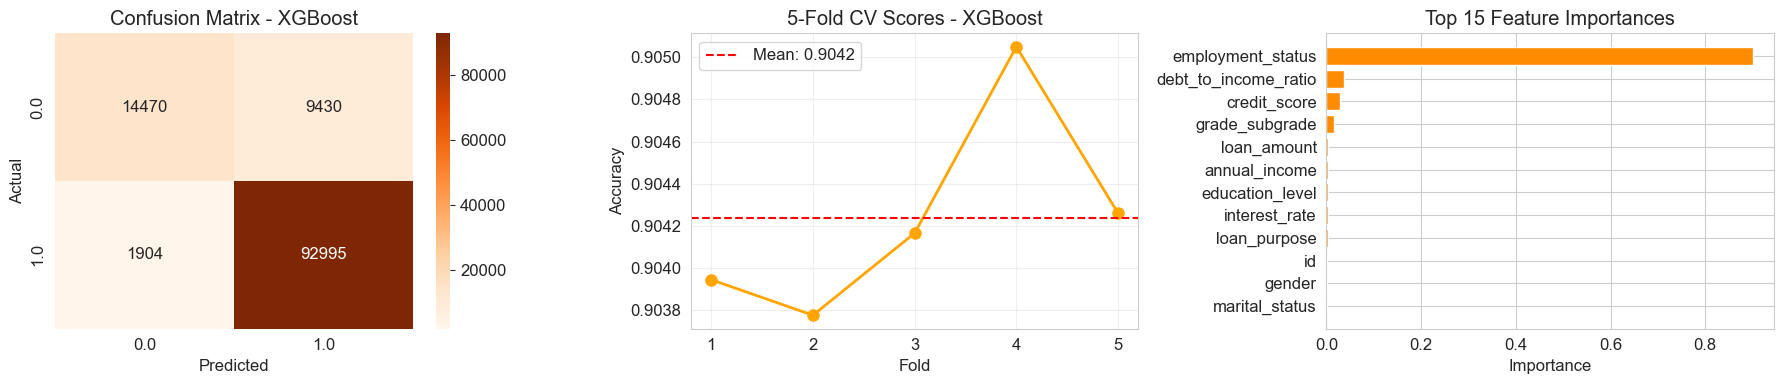


 ALL 3 MODELS TRAINED SUCCESSFULLY!

  Total training time: Approximately 1-3 minutes
 Models ready for comparison and deployment


In [58]:

# CELL 15: TRAIN MODEL 3 - XGBOOST (FAST - 8 combinations instead of 108)

print("\n" + "="*70)
print("TRAINING: XGBOOST (OPTIMIZED)")
print("="*70)

name = 'XGBoost'
config = models[name]

print(f"\n Starting Grid Search with 5-Fold CV...")
print(f"   Parameters: {config['params']}")
print(f"     Estimated time: 30-60 seconds...")

# Grid Search
grid_search_xgb = GridSearchCV(
    config['model'],
    config['params'],
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_scaled, y_train)

# Get best model
best_xgb = grid_search_xgb.best_estimator_

print(f"\n Grid Search completed!")
print(f"   Best parameters: {grid_search_xgb.best_params_}")
print(f"   Best CV score: {grid_search_xgb.best_score_:.4f}")

# Cross-validation scores
cv_scores_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\n 5-Fold CV Scores: {cv_scores_xgb}")
print(f"   Mean: {cv_scores_xgb.mean():.4f}")
print(f"   Std: {cv_scores_xgb.std():.4f}")

# Test predictions
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n Test Set Performance:")
print(f"   Accuracy: {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")

print(f"\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names_str))
# TRAIN ACCURACY
y_train_pred_xgb = best_xgb.predict(X_train_scaled)
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)

# TEST ACCURACY
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n MODEL PERFORMANCE:")
print(f"   Train Accuracy: {train_accuracy_xgb:.4f} ({train_accuracy_xgb*100:.2f}%)")
print(f"   Test Accuracy:  {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")
print(f"   Difference:     {abs(train_accuracy_xgb - test_accuracy_xgb):.4f}")


print(f"\n Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)

# Feature Importance
feature_importance_xgb = pd.DataFrame({
    'feature': column_names,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Confusion Matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
axes[0].set_title('Confusion Matrix - XGBoost')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# CV Scores
axes[1].plot(range(1, 6), cv_scores_xgb, marker='o', linestyle='-', linewidth=2, markersize=8, color='orange')
axes[1].axhline(y=cv_scores_xgb.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores_xgb.mean():.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('5-Fold CV Scores - XGBoost')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Feature Importance
top_features_xgb = feature_importance_xgb.head(15)
axes[2].barh(range(len(top_features_xgb)), top_features_xgb['importance'], color='darkorange')
axes[2].set_yticks(range(len(top_features_xgb)))
axes[2].set_yticklabels(top_features_xgb['feature'])
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 15 Feature Importances')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" ALL 3 MODELS TRAINED SUCCESSFULLY!")
print("="*70)
print("\n  Total training time: Approximately 1-3 minutes")
print(" Models ready for comparison and deployment")

In [59]:
# CELL 17: MODEL COMPARISON AND SELECTION

print("\n" + "="*70)
print("MODEL COMPARISON AND BEST MODEL SELECTION")
print("="*70)

# Compile results
results = {
    'Logistic Regression': {
        'model': best_lr,
        'best_params': grid_search_lr.best_params_,
        'cv_mean': cv_scores_lr.mean(),
        'cv_std': cv_scores_lr.std(),
        'cv_scores': cv_scores_lr,
        'test_accuracy': test_accuracy_lr,
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr,
        'confusion_matrix': cm_lr
    },
    'Random Forest': {
        'model': best_rf,
        'best_params': grid_search_rf.best_params_,  # Fixed reference to RF params
        'cv_mean': cv_scores_rf.mean(),
        'cv_std': cv_scores_rf.std(),
        'cv_scores': cv_scores_rf,
        'test_accuracy': test_accuracy_rf,
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf,
        'confusion_matrix': cm_rf
    },
    'XGBoost': {
        'model': best_xgb,
        'best_params': grid_search_xgb.best_params_,  # Fixed reference to XGB params
        'cv_mean': cv_scores_xgb.mean(),
        'cv_std': cv_scores_xgb.std(),
        'cv_scores': cv_scores_xgb,
        'test_accuracy': test_accuracy_xgb,
        'predictions': y_pred_xgb,
        'probabilities': y_pred_proba_xgb,
        'confusion_matrix': cm_xgb
    }
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("\n MODEL COMPARISON TABLE:")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_score = comparison_df.iloc[0]['Test Accuracy']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"   CV Mean: {results[best_model_name]['cv_mean']:.4f}")
print(f"   CV Std: {results[best_model_name]['cv_std']:.4f}")
print(f"   Best Parameters: {results[best_model_name]['best_params']}")



MODEL COMPARISON AND BEST MODEL SELECTION

 MODEL COMPARISON TABLE:
              Model  CV Mean   CV Std  Test Accuracy
            XGBoost 0.904239 0.000439       0.904595
      Random Forest 0.902356 0.000867       0.901565
Logistic Regression 0.892297 0.000651       0.890496

 BEST MODEL: XGBoost
   Test Accuracy: 0.9046 (90.46%)
   CV Mean: 0.9042
   CV Std: 0.0004
   Best Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}


In [60]:

# CELL 18: SAVE BEST MODEL AND RESULTS

print("\n" + "="*70)
print("SAVING BEST MODEL AND RESULTS")
print("="*70)

# Save best model
joblib.dump(best_model, 'models/best_model.pkl')
print(f" Best model saved: 'models/best_model.pkl'")

# Save all results
with open('models/model_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print(f" All results saved: 'models/model_results.pkl'")

# Save comparison DataFrame
comparison_df.to_csv('models/model_comparison.csv', index=False)
print(f" Comparison table saved: 'models/model_comparison.csv'")

print("\n All model artifacts saved successfully!")


# CELL 19: GENERATE BASELINE PREDICTIONS

print("\n" + "="*70)
print("GENERATING BASELINE PREDICTIONS")
print("="*70)

# Select samples from test set for baseline
num_baseline = min(10, len(X_test))
print(f"Generating {num_baseline} baseline predictions from test set...")

baseline_samples = X_test.iloc[:num_baseline].copy()
baseline_samples_scaled = scaler.transform(baseline_samples)
baseline_predictions = best_model.predict(baseline_samples_scaled)
baseline_predictions_proba = best_model.predict_proba(baseline_samples_scaled)
baseline_actual = y_test[:num_baseline]

print(f"\n Baseline predictions generated!")

# Display baseline predictions
print("\n" + "="*70)
print(f"BASELINE PREDICTIONS (First {num_baseline} Test Samples)")
print("="*70)

for i in range(num_baseline):
    pred_label = le_target.inverse_transform([baseline_predictions[i]])[0]
    actual_label = le_target.inverse_transform([baseline_actual[i]])[0]
    confidence = baseline_predictions_proba[i].max()
    
    print(f"\n{'─'*70}")
    print(f"Sample {i+1}:")
    print(f"  Predicted: {pred_label} (Code: {baseline_predictions[i]})")
    print(f"  Actual: {actual_label} (Code: {baseline_actual[i]})")
    print(f"  Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"  Probabilities:")
    for j, class_name in enumerate(le_target.classes_):
        print(f"    {class_name}: {baseline_predictions_proba[i][j]:.6f}")
    print(f"  Match: {' Correct' if baseline_predictions[i] == baseline_actual[i] else '✗ Wrong'}")

# Save baseline predictions
baseline_data = {
    'samples': baseline_samples,
    'samples_scaled': baseline_samples_scaled,
    'predictions': baseline_predictions,
    'probabilities': baseline_predictions_proba,
    'actual': baseline_actual
}

with open('models/baseline_predictions.pkl', 'wb') as f:
    pickle.dump(baseline_data, f)
print(f"\n Baseline data saved: 'models/baseline_predictions.pkl'")

# Create detailed baseline CSV
baseline_df = pd.DataFrame({
    'sample_id': range(1, num_baseline + 1),
    'prediction': le_target.inverse_transform(baseline_predictions),
    'prediction_code': baseline_predictions,
    'actual': le_target.inverse_transform(baseline_actual),
    'actual_code': baseline_actual,
    'confidence': baseline_predictions_proba.max(axis=1),
    'match': baseline_predictions == baseline_actual
})

# Add feature values
for col in column_names:
    baseline_df[col] = baseline_samples[col].values

# Add probabilities for each class
for i, class_name in enumerate(le_target.classes_):
    baseline_df[f'prob_{class_name}'] = baseline_predictions_proba[:, i]

baseline_df.to_csv('models/baseline_predictions.csv', index=False)
print(f" Baseline CSV saved: 'models/baseline_predictions.csv'")

print(f"\n{'='*70}")
print("BASELINE PREDICTIONS SUMMARY")
print('='*70)
print(f"Total samples: {num_baseline}")
print(f"Correct predictions: {(baseline_predictions == baseline_actual).sum()}")
print(f"Accuracy: {(baseline_predictions == baseline_actual).mean():.4f}")

# Display first 3 rows of baseline CSV (for verification)
print(f"\n Sample of baseline_predictions.csv (first 3 rows):")
print(baseline_df.head(3).to_string(index=False))




SAVING BEST MODEL AND RESULTS
 Best model saved: 'models/best_model.pkl'
 All results saved: 'models/model_results.pkl'
 Comparison table saved: 'models/model_comparison.csv'

 All model artifacts saved successfully!

GENERATING BASELINE PREDICTIONS
Generating 10 baseline predictions from test set...

 Baseline predictions generated!

BASELINE PREDICTIONS (First 10 Test Samples)

──────────────────────────────────────────────────────────────────────
Sample 1:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.9666 (96.66%)
  Probabilities:
    0.0: 0.033390
    1.0: 0.966610
  Match:  Correct

──────────────────────────────────────────────────────────────────────
Sample 2:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.9957 (99.57%)
  Probabilities:
    0.0: 0.004323
    1.0: 0.995677
  Match:  Correct

──────────────────────────────────────────────────────────────────────
Sample 3:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.

In [61]:
# CELL 20: FINAL SUMMARY AND CHECKLIST (STREAMLINED)

print("\n" + "="*70)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*70)

# Key Results
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"CV Mean Accuracy: {results[best_model_name]['cv_mean']:.4f}")
print(f"CV Std: {results[best_model_name]['cv_std']:.4f}")

# Essential Checklist
print("\n" + "="*70)
print("TASK 1 CHECKLIST - ESSENTIALS")
print("="*70)
checklist = [
    'Three models trained',
    'Includes Gradient Boosting (XGBoost)',
    'Grid Search hyperparameter tuning',
    '5-Fold Cross-Validation',
    'Best model selected and saved',
    'Scaler saved',
    'Column structure saved'
]

for task in checklist:
    print(f"   {task}")

# Next steps
print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("1. Deploy Flask REST API")
print("2. Integrate frontend")
print("3. Record demonstration video")
print("="*70)



TRAINING COMPLETE - FINAL SUMMARY

Best Model: XGBoost
Test Accuracy: 0.9046 (90.46%)
CV Mean Accuracy: 0.9042
CV Std: 0.0004

TASK 1 CHECKLIST - ESSENTIALS
   Three models trained
   Includes Gradient Boosting (XGBoost)
   Grid Search hyperparameter tuning
   5-Fold Cross-Validation
   Best model selected and saved
   Scaler saved
   Column structure saved

NEXT STEPS
1. Deploy Flask REST API
2. Integrate frontend
3. Record demonstration video
